In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient
from class_tou import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

In [40]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

In [41]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [42]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [43]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

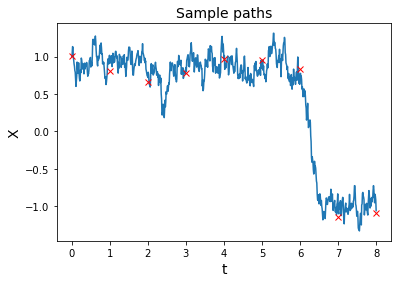

In [44]:
# Plot paths
plt.plot(t,X)
plt.plot(t[::100], obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dZ_t = [-r(Z_t - m(t)) + m'(t)]dt + \sigma dW_t$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + r(Z_{t}-m(t))-m'(t)}{\sigma}|^{2}dt]$$

where the relevant functions

$$m(t) = \alpha (B(t, \beta) - 1) + m_{0}$$

$$m'(t) = \alpha \beta B(t, \beta - 1)$$

$$B(s, \beta) = (s + 1)^{\beta}$$

Please note that $E(Z_t) = m(t)$. Here we consider a variational process with a $\textbf{linear mean function}$, i.e. $\beta = 1$, which results in $m(t) = \alpha t + m_{0}$. Our variational parameters, thus, include $r, \alpha, m_{0}$

In [45]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
    
    def KL(self, prior_drift):
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        # Evaluate the drift function of the approximating processes
        g_of_x = -r * (self.ou.trj - m(t)) + m_(t)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        return 0.5 * torch.trapezoid(F_of_X, x=t).reshape(-1, 1)
        
    
#     def KL_Riemann(self):
#         """
#             1. Compute the Riemann approximation to integral in KL divergence
            
#         """
#         # Save parameter specification from ou class
#         alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
            
#         def B(s, beta):
#             return (s+1) ** beta
        
#         def m(s):
#             return alpha * (B(s, beta) - 1) + m0
            
#         def m_(s):
#             return alpha * beta * B(s, beta-1)
        
#         t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        
#         # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        
# #         func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
# #                 - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
# #                 + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
# #                                                                                 alpha * beta * B(s, beta-1))
#         def integral(s, z):
#             return (16 * z * z * (1 - z * z) ** 2) - ((-r * (z - m(s)) + m_(s)) ** 2)
    
#         num = integral(t, self.ou.trj)

#         return -0.5 * torch.trapezoid(num, x=t).reshape(-1, 1) / (sigma * sigma)
# #         return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
#     def KL_Ito(self):
#         """
#             2. Compute the rest
#         """

#         alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
#         D = alpha.shape[0]
        
#         z0 = self.ou.z0

#         z1 = self.ou.trj[:, -1].reshape(D, 1)
        
#         t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)

#         t0 = t[:, 0]
#         t1 = t[:, -1]
        
                
#         def m(s):
#             return alpha * (B(s, beta) - 1) + m0
            
#         def m_(s):
#             return alpha * beta * B(s, beta-1)
        
#         def B(s, beta):
#             return (s+1) ** beta
        
# #         def A(s, u):
# #             return (-1 * (u ** 4) + 0.5 * (4+r) * (u ** 2) - u * r * (alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
#         def A(s, u):
#             return (-1 * u ** 4 + 0.5 * (4 + r) * u * u - (r * m(s) + m_(s)) * u) / (sigma * sigma)
                
#         def integral_01(t0, t1):
#             return r * alpha * B(t1, beta) + alpha * beta * B(t1, beta-1) - r * alpha * B(t0, beta) - alpha * beta * B(t0, beta-1)
        
#         return A(t1, z1) - A(t0, z0) + integral_01(t0, t1) / (sigma * sigma) - 0.5 * (4 + r) * (t1 - t0) + 6 * torch.trapezoid(self.ou.trj ** 2, x=t)
# #         return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [46]:
import tqdm as tq

In [ ]:
D = 50
S = 100
learning_rate = 0.00005
lr = learning_rate
IT = 200
dN = 200
z0 = obs[0]

# Linear mean function
beta_ = torch.tensor([1.])
beta_D = beta_.repeat(D, 1)
beta_S = beta_.repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

sde_sigma_D = torch.tensor([sde_sigma]).repeat(D, 1)
sde_sigma_S = torch.tensor([sde_sigma]).repeat(S, 1)
for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1) + 4.
    if t > 1:
        r_ = torch.tensor([4.])
    m0_ = torch.randn(1) + obs[t].clone().detach()
    
    i = 0
    for i in range(IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL(prior_drift)
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = LL_ - kl_
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("ELBO = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)

        gradient = tou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, m0_D, r_D, sde_sigma_D]).view(-1, D, 1))
#         print("scores = ", scores)
        f_of_X = -elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL(prior_drift)
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * gradient['m0'])
        alpha_grad = torch.nanmean(f_of_X * gradient['alpha'])
        r_grad = torch.nanmean(f_of_X * gradient['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_.repeat(S,1), beta = beta_S, sigma = sde_sigma_S, r = r_.repeat(S,1), dN = dN, timegrid='True')

    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_61384/830024755.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma = torch.tensor(ou.sigma)


alpha =  [-0.3922574] m0 =  [2.49474317] r =  [4.3421407]
ELBO =  -812.4552789406761
alpha =  [-0.87001437] m0 =  [1.76826708] r =  [4.3087997]
ELBO =  -16.989342398113443
alpha =  [-0.9110439] m0 =  [1.67918974] r =  [4.3087378]
ELBO =  -11.498019433229247
alpha =  [-0.9220966] m0 =  [1.63345772] r =  [4.310063]
ELBO =  -8.447380880565808


 12%|█████▋                                       | 1/8 [00:09<01:03,  9.01s/it]

alpha =  [-0.01040225] m0 =  [1.52619537] r =  [4.198326]
ELBO =  -83.90018569529886
alpha =  [-0.23962906] m0 =  [1.25511958] r =  [4.1980753]
ELBO =  -9.458128537033899
alpha =  [-0.3218837] m0 =  [1.16289364] r =  [4.200738]
ELBO =  -4.570672069649859
alpha =  [-0.36555088] m0 =  [1.11443308] r =  [4.203334]
ELBO =  -4.1809377806017665


 25%|███████████▎                                 | 2/8 [00:18<00:54,  9.02s/it]

alpha =  [-0.01122175] m0 =  [1.42806573] r =  [3.9999948]
ELBO =  -55.21284349861467
alpha =  [-0.20032087] m0 =  [1.20893694] r =  [4.0036173]
ELBO =  -10.295820365639802
alpha =  [-0.257452] m0 =  [1.14055953] r =  [4.006532]
ELBO =  -5.956377835329956
alpha =  [-0.28799596] m0 =  [1.10245144] r =  [4.0109243]
ELBO =  -4.076790615912926


Trace plot: ELBO

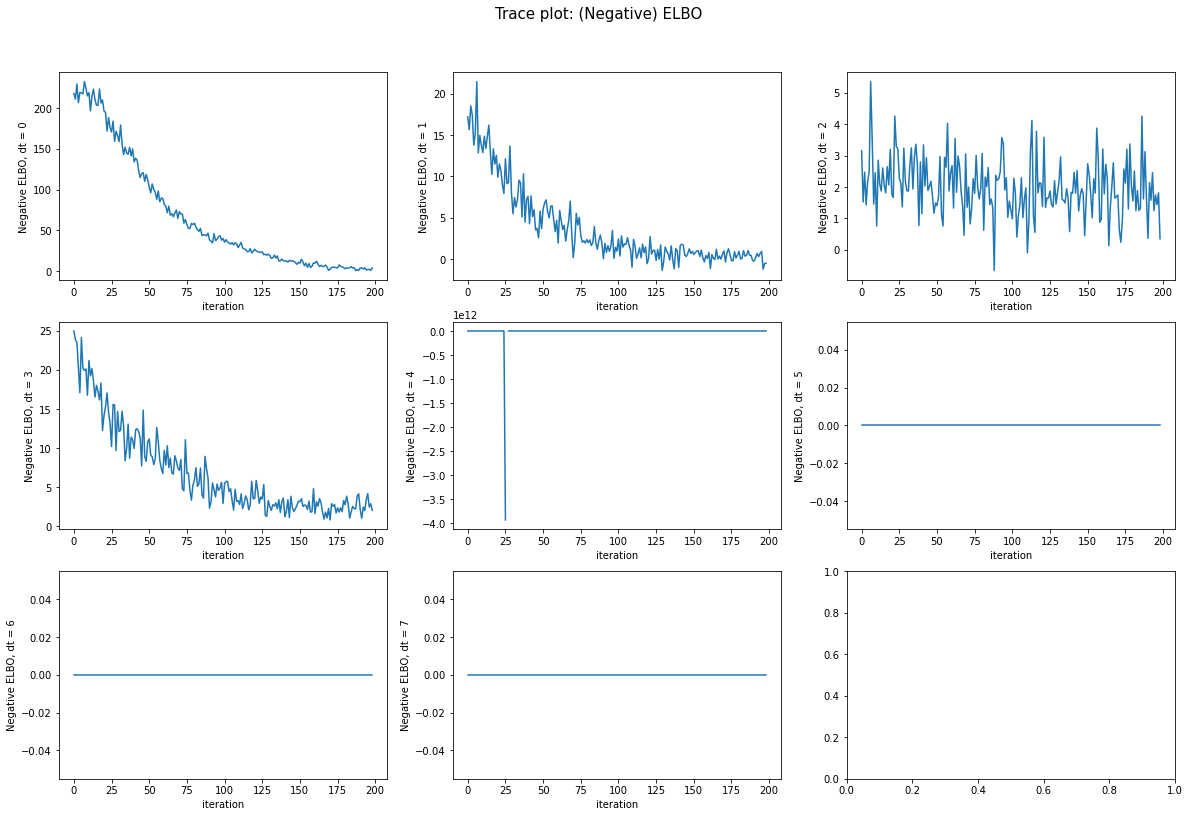

In [50]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

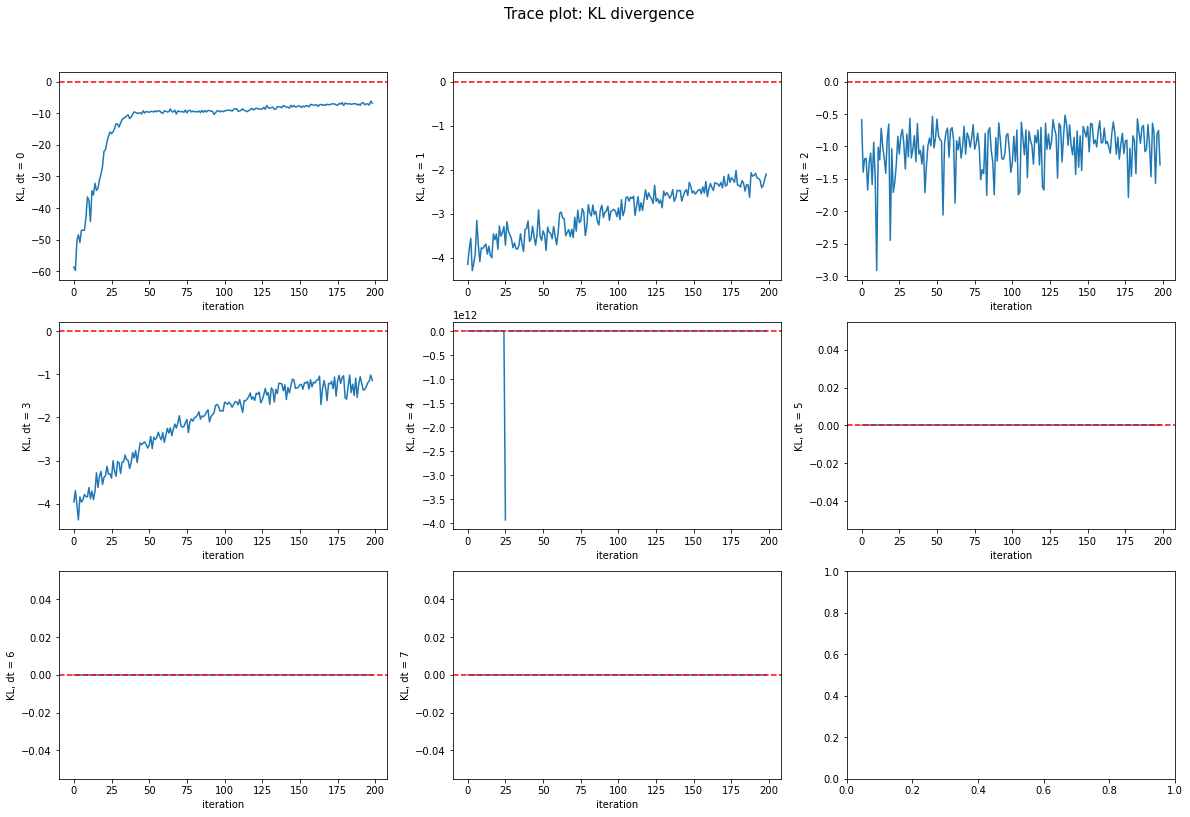

In [51]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

In [ ]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

In [ ]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-inhomogeneous process with linear mean function")
plt.show()

In [ ]:
import pickle

In [ ]:
with open('EX03_DW-SDE', 'wb') as f:
    pickle.dump(true_sde_pts, f)
    pickle.dump(true_sde_trj, f)
    pickle.dump(obs, f)
    pickle.dump(obs_time, f)
    pickle.dump(obs_sigma, f)
    pickle.dump(sde_sigma, f)